In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
import pandas as pd
from sympy import symbols, solve
import scipy.linalg as la

from scipy.interpolate import pchip_interpolate

from matplotlib.pyplot import cm

In [2]:
plt.rcParams["figure.figsize"] = [14, 10]
plt.style.use("zach")
plt.rcParams["text.usetex"] = False

cmap = cm.get_cmap('plasma', 17)

In [3]:
from scipy.special import erfc
from math import pi
from numpy import log
from numpy import sqrt
from numpy import e

In [133]:
# Importing velues from Srini's code

%store -r noise
%store -r el
%store -r mv_comb

%store -r high_el
%store -r high_ell_noise
%store -r high_dll_noise

%store -r el_camb
%store -r cl_cmb
%store -r dl_cmb

In [120]:
# Common Parameters

A_s = 2.100549e-09
A_l = 0.05
f_sky = 3/100
mi = 11
ma = 1000
l = np.linspace(2, 1000, 999)

k_center = np.geomspace(1e-6, 1e2, 17)
delta = k_center[1]/k_center[0]
sigma = 0.1

deltas = 2/100

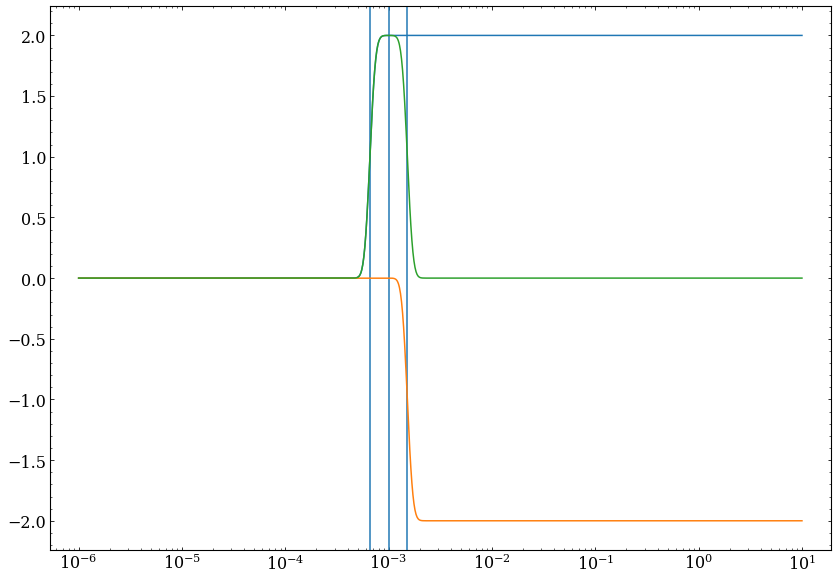

In [123]:
fig, ax = plt.subplots()

kcenter = 1e-3
delta = np.log(10)
k_left = kcenter / delta**.5
k_right = kcenter * delta**.5

ax.axvline(kcenter)
ax.axvline(k_left)
ax.axvline(k_right)
#k = np.geomspace(1e-3, 1e-1, 1000)
left_edge = erfc((np.log(k_left) - np.log(k)) / (sigma * sqrt(2)))
right_edge = - erfc((np.log(k_right) - np.log(k)) / (sigma * sqrt(2)))
ax.semilogx(
    k, left_edge
)
ax.semilogx(
    k, right_edge
)
ax.semilogx(k, left_edge + right_edge)
ax.set_xscale("log")

# 1. Functions

In [124]:
# Importing Example Primordial Power Spectrum with Tensor Data

file = '/Users/yinqiuliu/class/external/external_Pk/Pk_example_w_tensors.dat'
Pk_example = np.loadtxt(file, unpack=True)
k = Pk_example[0]

## 1-1. Function defining the derivative "bumps"

In [125]:
def pri_dev(k, k_center, delta, r_p, r_o):
    sigma = 0.1
    A_s = 2.100549e-09
#     delta = k_center[1]/k_center[0]
 
    # Setting Ranges
    k_left = k_center / sqrt(delta)
    k_right = k_center * sqrt(delta)

    left_edge = erfc((np.log(k_left) - np.log(k)) / (sigma * sqrt(2)))
    right_edge = erfc((np.log(k_right) - np.log(k)) / (sigma * sqrt(2)))

    # Subtraction
    dev_bump = left_edge - right_edge

    # Varying peak
    ro = A_s * r_o
    rp = A_s * r_p
    c_s = (rp-ro)/2

    peak = dev_bump*c_s

    step = peak + ro

    return step

## 1-2. Function Generating B-mode Power Spectrum

In [126]:
def Cl_bb_r(r, l): 
    # Importing new Data
    Pk_example[0] = k
    Pk_example[2] = A_s * r
    new_file = '/Users/yinqiuliu/class/external/external_Pk/newdata.dat'
    np.savetxt(new_file, Pk_example.transpose())

    # Cosmological parameters and other CLASS parameters
    common_settings = {# Set primordial pk to external files
                        'Pk_ini_type': 'external_Pk',
                        'command': 'cat external/external_Pk/newdata.dat', 
                        'modes':'t',
                       # output and precision parameters
                        'output':'pCl',
                        'l_max_tensors':l}
    #
    M = Class()
    M.set(common_settings)
    M.compute()

    cl = M.raw_cl(l)
    ell = cl['ell']
    # Converting y axis to dimensionless total [l(l+1)/2pi] C_l's
    factor = (ell*(ell+1))/(2*pi)
    bb = (factor * cl['bb'])
#     plt.loglog(ell[2:1001], cl_bb[2:1001])

    M.empty()
    return bb

## 1-3. Derivatives Function

In [127]:
def derivative(b_plus, b_minus, delta_rp):
    df = (b_plus - b_minus) / (2 * delta_rp)
    return df

In [139]:
def bins_derivative(k_center, r, l):
    delta = k_center[1]/k_center[0]
    dfs_sp = []
    for i in range(17):
        dfs = []
        for sign in [1, -1]:
            pks = pri_dev(k, k_center[i], delta, r*(1+sign*deltas), r)

            # Importing new Data
            Pk_example[2] = pks
            new_file = '/Users/yinqiuliu/class/external/external_Pk/newdata.dat'
            np.savetxt(new_file, Pk_example.transpose())

            # Cosmological parameters and other CLASS parameters
            common_settings = {# Set primordial pk to external files
                                'Pk_ini_type': 'external_Pk',
                                'command': 'cat external/external_Pk/newdata.dat', 
                                'modes':'t',
                               # output and precision parameters
                                'output':'pCl',
                                'l_max_tensors':l,
            }
            #
            M = Class()
            M.set(common_settings)
            M.compute()

            cl = M.raw_cl(l)
            ell = cl['ell']
            # Converting y axis to dimensionless total [l(l+1)/2pi] C_l's
            factor = (ell*(ell+1))/(2*pi)
            cl_bb = (factor * cl['bb'])

            dfs.append(cl_bb)
            # Append

            M.empty()

        dfs_sp.append(derivative(dfs[0], dfs[1], r*deltas))
    return(dfs_sp)

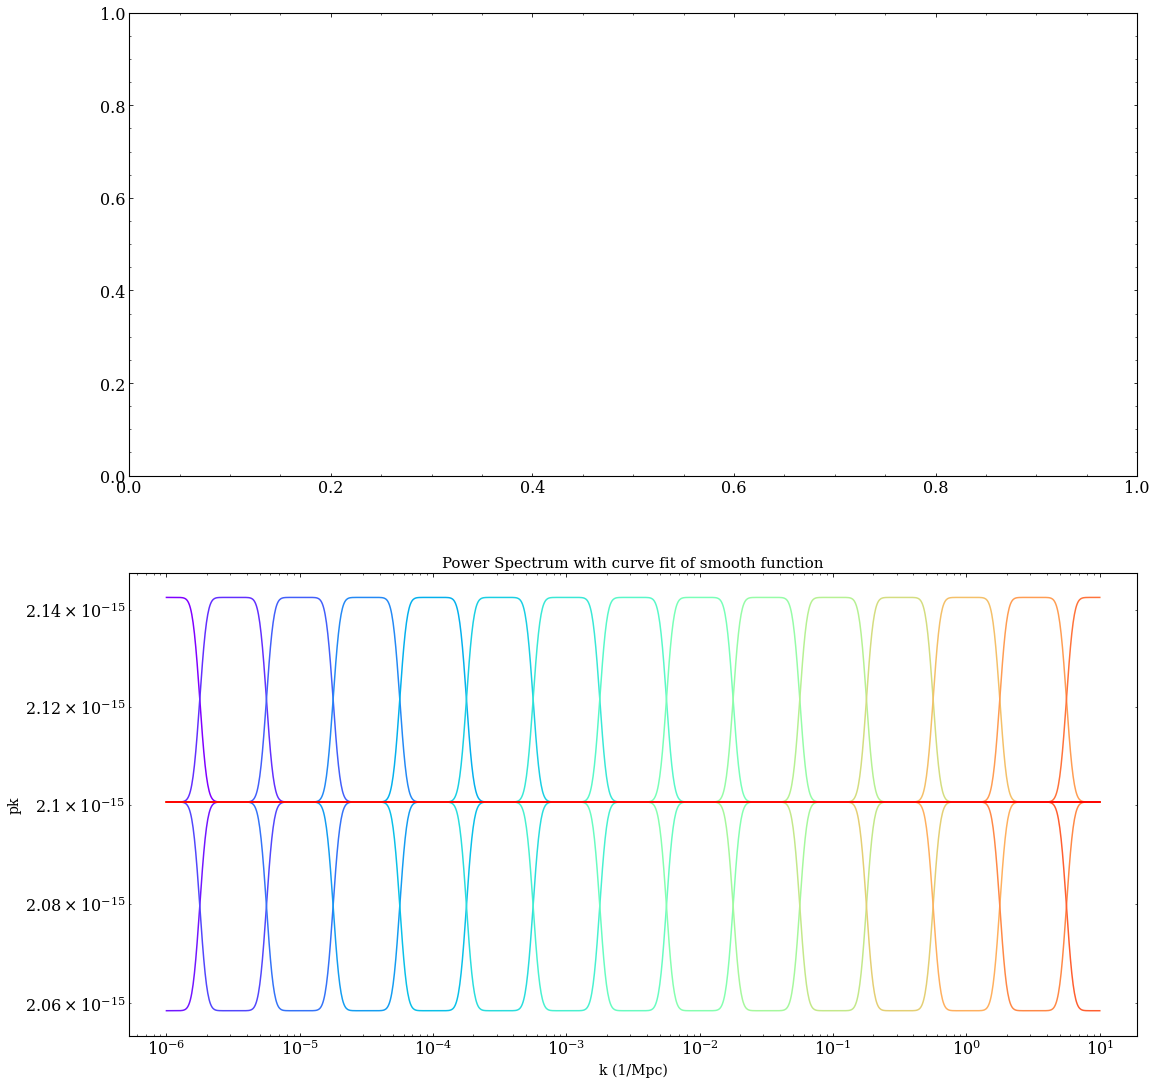

In [20]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(15,15)
fig.tight_layout(h_pad = 5.0)


colors = cm.rainbow(np.linspace(0, 1, 34))
l = np.linspace(2, 1000, 999)
delta = k_center[1]/k_center[0]

index = 0
for i in range(17):
    for sign in [1, -1]:
        pks = pri_dev(k, k_center[i], delta, 1e-6*(1+sign*deltas), 1e-6)
    
        plt.loglog(k, pks, color = colors[index])
        index += 1

        plt.xlabel('k (1/Mpc)', fontsize = 14)
        plt.ylabel('pk', fontsize = 14)
        plt.title('Power Spectrum with curve fit of smooth function', fontsize = 15)

        
# A_t = np.linspace(1, 17, 17)
# index = 0
# for i in range(17):
#     ax[1].loglog(l, (bb_4)[2:1001], color = colors[index], label = str(A_t[index])+'th $A_t$ bin:' + ' ' + 'is non zero')
#     index += 1
    
#     ax[1].set_xlabel('Multipole Moment l', fontsize = 14)
#     ax[1].set_ylabel('l(l+1)$C_{l}^{BB}$/$2\\pi$', fontsize = 14)
#     ax[1].set_title('BB Power Spectrum', fontsize = 15)
#     ax[1].legend(loc='center left', bbox_to_anchor=(1, 1))
# ax[1].plot(el[11:500], noise[11:500], 'lime', ls = '--', lw = 1., label = 'MV noise')
# ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 2. Tensor - B mode Power Spectrum Derivatives

In [110]:
bb_4 = Cl_bb_r(1e-4, 1000)
bb_5 = Cl_bb_r(1e-5, 1000)
bb_6 = Cl_bb_r(1e-6, 1000)

In [140]:
dfs_4 = bins_derivative(k_center, 1e-4, 1000)
dfs_5 = bins_derivative(k_center, 1e-5, 1000)
dfs_6 = bins_derivative(k_center, 1e-6, 1000)

Text(0.5, 0, 'Multipole Moment l')

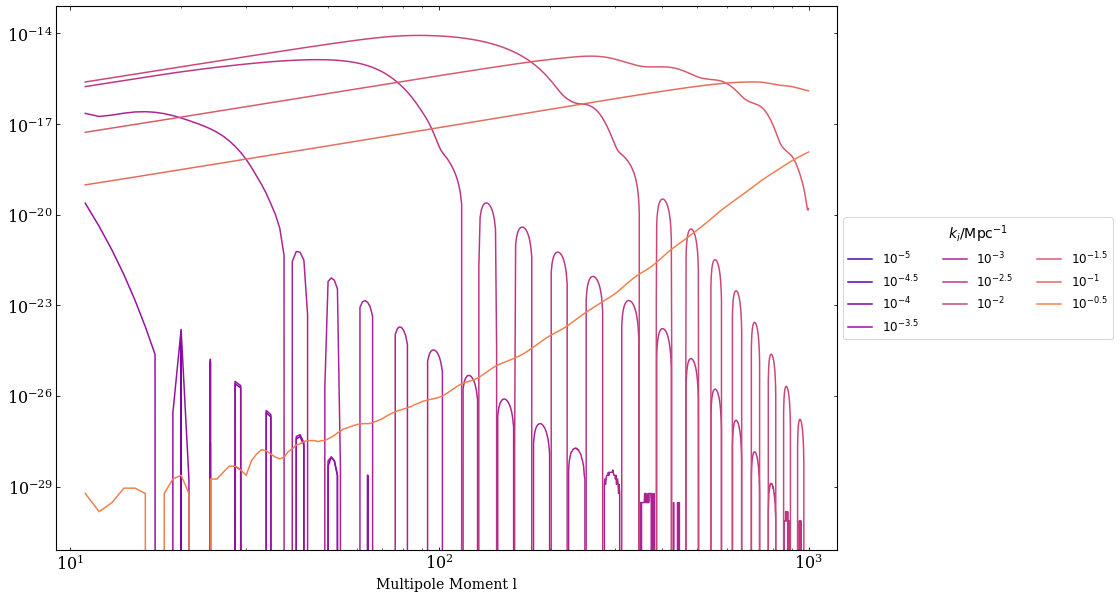

In [142]:
fig, ax = plt.subplots()

for i in range(2, 12):
    label = f"$10^{{{np.log10(k_center[i]):.2g}}}$"
    ax.loglog(np.arange(11, 1001), dfs_4[i][11:], color=cmap.colors[i], label=label)
    
ax.legend(title=r"$k_i / \mathrm{Mpc}^{-1}$", loc="center left", bbox_to_anchor=(1, 0.5), ncol=3)
ax.set_xlabel('Multipole Moment l', fontsize = 14)

# 3. Forecasring the Fisher Matrix

$$
F_{ij}
= \sum_{\ell} \frac{2 \ell + 1}{2}
\left[ C_\ell + N_\ell \right]^{-2}
\frac{\partial C_\ell}{\partial \theta_i}
\frac{\partial C_\ell}{\partial \theta_j}
$$

$$
\mathrm{Cov}_{ij} = \left( F^{-1} \right)_{ij}
$$

$$
\sigma_i^2 = \mathrm{Cov}_{ii}
$$

$$
\mathrm{Cov}
= \left(
\begin{array}{2}
     \langle x_1 x_1 \rangle & \langle x_1 x_2 \rangle \\ 
     \langle x_1 x_2 \rangle & \langle x_2 x_2 \rangle
\end{array}
\right)
$$

$$
\mathrm{Cov}
= \left(
\begin{array}{2}
    \sigma_1^2 & \sigma_{12}^2 \\ \sigma_{12}^2 & \sigma_2^2
\end{array}
\right)
$$

In [146]:
# mi and ma is the range of multipole (l)

def fisher_forecast(Cl_bb, df, f_sky, mi, ma, n_params):

    n_ell = (((mv_comb[mi:ma]/(2.726**2))*10**-12)*(el[mi:ma]*(el[mi:ma]+1)))/(2*np.pi)
    
    F = np.zeros((n_params, n_params))
    for i in range(n_params):
        for j in range(n_params):
            Fij_ell = (((2*l[mi-2:ma-2] + 1)/2) * ((Cl_bb[mi+1:ma+1] + n_ell)**(-2)) * ((df[i])[mi+1:ma+1]*(df[j])[mi+1:ma+1]))*f_sky
            F[i, j] = np.sum(Fij_ell) 
    cov = la.inv(F)
    sigmas = np.diagonal(cov)
    
    return sigmas

In [147]:
new_sigma_4 = fisher_forecast(bb_4, dfs_4[2:12], f_sky, mi, ma, 10)
pk_err_4 = new_sigma_4 * A_s
pk_err_4

array([2.35777206e+15, 6.47390718e+13, 2.63713403e+08, 8.42206079e-04,
       3.61466173e-12, 3.57957860e-16, 1.18461442e-17, 4.73435913e-15,
       5.56127377e-12, 3.67691858e-03])

In [148]:
new_sigma_5 = fisher_forecast(bb_5, dfs_5[2:12], f_sky, mi, ma, 10)
pk_err_5 = new_sigma_5 * A_s
pk_err_5

array([5.35393188e+15, 4.51073897e+13, 1.84005694e+08, 7.84899944e-04,
       3.19977239e-12, 2.75800449e-16, 9.49743908e-18, 4.63163360e-15,
       5.52813382e-12, 3.67613407e-03])

In [149]:
new_sigma_6 = fisher_forecast(bb_6, dfs_6[2:12], f_sky, mi, ma, 10)
pk_err_6 = new_sigma_6 * A_s
pk_err_6

array([3.11146158e+15, 1.12177542e+13, 4.54662296e+07, 7.79161746e-04,
       3.15951882e-12, 2.60502941e-16, 9.24572681e-18, 4.61984347e-15,
       5.52434034e-12, 3.67604425e-03])

# 4. Graph & Table

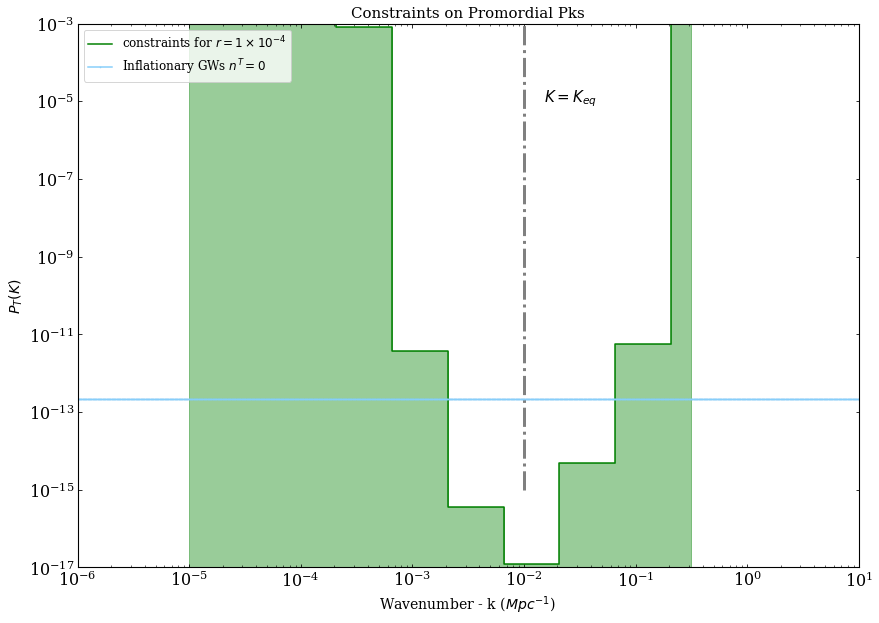

In [109]:
# r = 1e-4

plt.step(k_center[2:12], pk_err_4, drawstyle="steps", where = 'mid', color = 'green', label = 'constraints for $r = 1 \\times 10^{-4}$')
plt.fill_between(k_center[2:12], pk_err_4, step="mid", color = 'green', alpha=0.4)
plt.xlim([1e-6, 10])
plt.ylim([1e-17, 1e-3])
plt.vlines(1e-2, 1e-15, 2e3, linestyles='-.', color = 'gray', linewidth = 3)
plt.text(1.5e-2, 1e-5, '$K = K_{eq}$', fontsize = 15)

plt.loglog()


standard_pk = 1e-4*A_s*(k/0.05)**0
plt.loglog(k, standard_pk, marker = '.', color = 'lightskyblue', markersize = 1, label = 'Inflationary GWs $n^T = 0$')

plt.xlabel('Wavenumber - k ($Mpc^{-1}$) ', fontsize = 14)
plt.ylabel('$P_T(K)$', fontsize = 14)
plt.title('Constraints on Promordial Pks', fontsize = 15)

plt.legend()

In [28]:
%store -r pk_err_6_h

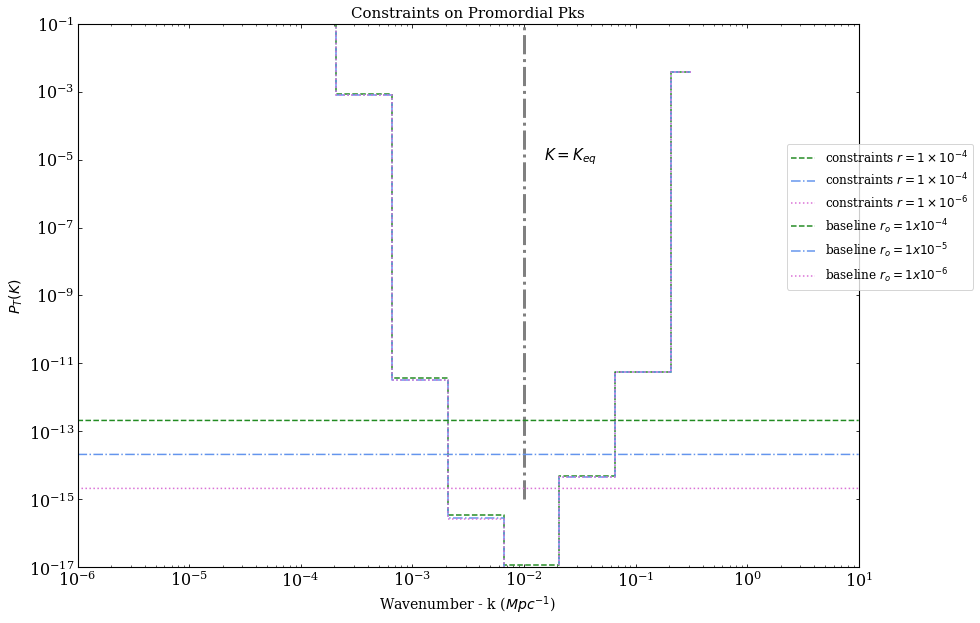

In [94]:
plt.step(k_center[2:12], pk_err_4, drawstyle="steps", where = 'mid', color = 'forestgreen', linestyle = '--', label = 'constraints $r = 1\\times10^{-4}$')
plt.step(k_center[2:12], pk_err_5, drawstyle="steps", where = 'mid', color = 'cornflowerblue', linestyle = '-.', label = 'constraints $r = 1\\times10^{-4}$')
plt.step(k_center[2:12], pk_err_6, drawstyle="steps", where = 'mid', color = 'orchid', linestyle = ':', label = 'constraints $r = 1\\times10^{-6}$')


plt.xlim([1e-6, 10])
plt.xlim([1e-6, 10])
plt.ylim([1e-17, 1e-1])
plt.vlines(1e-2, 1e-15, 2e3, linestyles='-.', color = 'gray', linewidth = 3)
plt.text(1.5e-2, 1e-5, '$K = K_{eq}$', fontsize = 15)

plt.loglog()


standard_pk = 1e-4*A_s*(k/0.05)**0
plt.loglog(k, standard_pk, color = 'forestgreen', ls = '--', label = 'baseline $r_o = 1 x 10^{-4}$')
plt.loglog(k, standard_pk*1e-1, color = 'cornflowerblue', ls = '-.', label = 'baseline $r_o = 1 x 10^{-5}$')
plt.loglog(k, standard_pk*1e-2, color = 'orchid', ls = ':', label = 'baseline $r_o = 1 x 10^{-6}$')


# standard_pk_2 = 0.003*A_s*(k/0.05)**0
# plt.loglog(k, standard_pk_2, marker = '.', color = 'lightskyblue', markersize = 1, label = 'baseline $r_o$')


plt.xlabel('Wavenumber - k ($Mpc^{-1}$) ', fontsize = 14)
plt.ylabel('$P_T(K)$', fontsize = 14)
plt.title('Constraints on Promordial Pks', fontsize = 15)

plt.legend(bbox_to_anchor=(0.9, 0.5))

In [80]:
cons_sigma_new = (1e-6*A_s)/pk_err_6

bin_num = np.linspace(1, 17, 17)

error_table = pd.DataFrame(
    {'Bin #':bin_num[2:12],
     '$1\times10^{-4}$': pk_err_4,
     '$1\times10^{-5}$': pk_err_5,
     '$1\times10^{-6}$': pk_err_6, 
     '# $\sigma$': cons_sigma_new,
    })

error_table

,Bin #,$1\times10^{-4}$,$1\times10^{-5}$,$1\times10^{-6}$,# $\sigma$
0,3.0,2.357772e+15,5.353932e+15,3.111462e+15,6.751004e-31
1,4.0,6.473907e+13,4.510739e+13,1.121775e+13,1.872522e-28
2,5.0,2.637134e+08,1.840057e+08,4.546623e+07,4.620020e-23
3,6.0,8.422061e-04,7.848999e-04,7.791617e-04,2.695909e-12
4,7.0,3.614662e-12,3.199772e-12,3.159519e-12,6.648319e-04
5,8.0,3.579579e-16,2.758004e-16,2.605029e-16,8.063437e+00
6,9.0,1.184614e-17,9.497439e-18,9.245727e-18,2.271913e+02
7,10.0,4.734359e-15,4.631634e-15,4.619843e-15,4.546797e-01
8,11.0,5.561274e-12,5.528134e-12,5.524340e-12,3.802353e-04
9,12.0,3.676919e-03,3.676134e-03,3.676044e-03,5.714156e-13


# 5. Tranform to Gravitational Wave & Compare with Copeland Paper

In [31]:
def gw_trans(k):
    W_r_h2 = 4.2e-5
    k_eq_inv_Mpc = 1e-2
    return (3/128) * W_r_h2 * (1/2 * (k_eq_inv_Mpc / k)**2 + 16/9)

In [95]:
# Copeland Data

f = np.array([4.8891974903863311e-19, 4.8891974903863311e-19, 7.7488558191112602e-19, 1.2281108837072114e-18,
              1.9464245791749626e-18, 3.0848750651733837e-18, 4.8891974903863315e-18, 7.7488558191112596e-18,
              1.2281108837072125e-17, 1.9464245791749624e-17, 3.0848750651733850e-17, 4.8891974903863309e-17,
              7.7488558191112600e-17, 1.2281108837072127e-16, 1.9464245791749625e-16, 3.0848750651733866e-16,
              4.8891974903863317e-16, 7.7488558191112565e-16,
])
energy_density = np.array([1, 6.025595860743568e-13, 2.454708915685034e-13, 3.801893963205613e-14,
                           6.025595860743568e-15, 3.090295432513592e-15, 2.089296130854041e-15, 
                           4.677351412871981e-16, 3.235936569296281e-16, 1.096478196143183e-15,
                           2.398832919019495e-15, 9.772372209558111e-15, 4.265795188015934e-14,
                           3.715352290971728e-13, 3.311311214825908e-09, 1.445439770745928e-07, 1, 1,
])

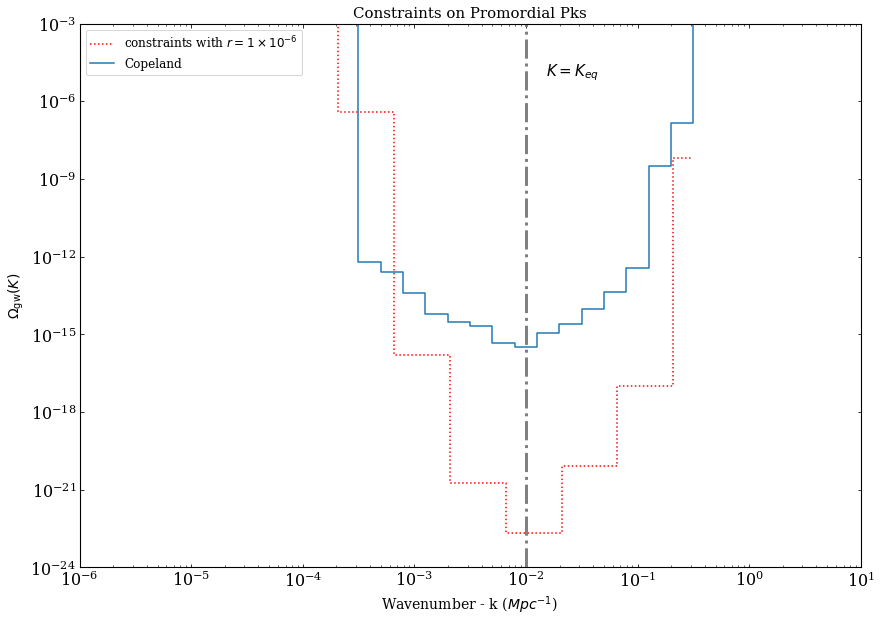

In [96]:
plt.step(k_center[2:12], gw_trans(k_center[2:12]) * pk_err_6, drawstyle="steps", where = 'mid', color = 'red', linestyle = ':', label = 'constraints with $r = 1\\times10^{-6}$')


plt.xlim([1e-6, 10])
plt.ylim([1e-24, 1e-3])
plt.axvline(1e-2, linestyle='-.', color = 'gray', linewidth = 3)
plt.text(1.5e-2, 1e-5, '$K = K_{eq}$', fontsize = 15)

plt.loglog()

plt.step(f/1.55e-15, energy_density, where="post", label = 'Copeland')


plt.xlabel('Wavenumber - k ($Mpc^{-1}$) ', fontsize = 14)
plt.ylabel('$\Omega_\mathrm{gw}(K)$', fontsize = 14)
plt.title('Constraints on Promordial Pks', fontsize = 15)

plt.legend()

In [34]:
gw_trans(k_center[2:12]) * pk_err_6

array([1.53142794e+15, 5.52143471e+11, 2.23858665e+05, 3.84857205e-07,
       1.61036725e-16, 1.73804306e-21, 2.07306531e-23, 8.31210899e-21,
       9.69478570e-18, 6.43488674e-09])

# 7. Lensing

In [35]:
def Cl_bb_lensed(r, l): 
    # Importing new Data
    Pk_example[0] = k
    Pk_example[2] = A_s * r
    new_file = '/Users/yinqiuliu/class/external/external_Pk/newdata.dat'
    np.savetxt(new_file, Pk_example.transpose())

    # Cosmological parameters and other CLASS parameters
    common_settings = {# Set primordial pk to external files
                        'Pk_ini_type': 'external_Pk',
                        'command': 'cat external/external_Pk/newdata.dat', 
                        'modes':'s',
                       # output and precision parameters
                        'output':'tCl, pCl, lCl',
                        'lensing':'yes',
                        'l_max_scalars':l}
    #
    M = Class()
    M.set(common_settings)
    M.compute()

    cl_lensed = M.lensed_cl(l)
    ell = cl_lensed['ell']
    # Converting y axis to dimensionless total [l(l+1)/2pi] C_l's
    factor = (ell*(ell+1))/(2*pi)
    bb = (factor * cl_lensed['bb'])
#     plt.loglog(ell[2:1001], cl_bb[2:1001])

    M.empty()
    return bb

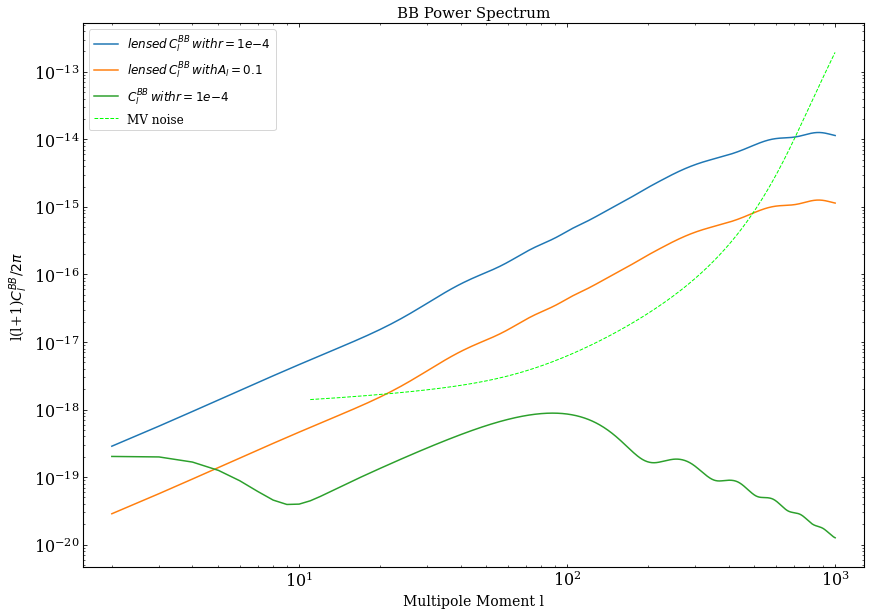

In [101]:
cl_lensed_4 = Cl_bb_lensed(1e-4, 1000)
l01 = cl_lensed_4 * 0.1

plt.loglog(l, cl_lensed_4[2:1001], label = '$lensed\,C_l^{BB}\,with r = 1e{-4}$')
plt.loglog(l, l01[2:1001], label = '$lensed\,C_l^{BB}\,with A_l = 0.1$')
plt.loglog(l, bb_4[2:1001], label = '$C_l^{BB}\,with r = 1e{-4}$')
plt.loglog(el[11:1001], noise[11:1001], 'lime', ls = '--', lw = 1., label = 'MV noise')


plt.xlabel('Multipole Moment l', fontsize = 14)
plt.ylabel('l(l+1)$C_{l}^{BB}$/$2\\pi$', fontsize = 14)
plt.title('BB Power Spectrum', fontsize = 15)

plt.legend()

# $C_l = C_l^{r} + A_l \times C_l^{lensed(A_l)} = r \times \frac{\partial{C_l}}{\partial{r}} + A_l \times \frac{\partial{C_l}}{\partial{A_l}}$ 

In [37]:
# mi and ma is the range of multipole (l)

def lensed_forecast(Cl_r, Cl_lensed, A_l, dfs, f_sky, mi, ma, n_params):

    Cl_Al = Cl_lensed * A_l
    
    
    n_ell = (((mv_comb[mi:ma]/(2.726**2))*10**-12)*(el[mi:ma]*(el[mi:ma]+1)))/(2*np.pi)
    
    F = np.zeros((n_params, n_params))
    for i in range(n_params):
        for j in range(n_params):
            Cl_total = Cl_r[mi+1:ma+1] + Cl_Al[mi+1:ma+1]
            Fij_ell = ((2*l[mi-2:ma-2] + 1)/2 * ((Cl_total + n_ell)**-2) * ((dfs[i])[mi+1:ma+1]*(dfs[j])[mi+1:ma+1]))*f_sky
            F[i, j] = np.sum(Fij_ell)
            print(F)
    cov = la.inv(F)
    print(cov)
    sigmas = np.diagonal(cov)**0.5
    
    sig_r = sigmas[0]
    sigma_al = sigmas[1]
    return sig_r, sigma_al

In [38]:
df_r = bb_4/1e-4
cl_al = cl_lensed_4 * A_l

dfs_lens = [df_r, cl_lensed_4]

lensed_forecast(bb_4, cl_al, A_l, dfs_lens, f_sky, mi, ma, 2)

[[3.81239366e+08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[3.81239366e+08 1.79870835e+07]
 [0.00000000e+00 0.00000000e+00]]
[[3.81239366e+08 1.79870835e+07]
 [1.79870835e+07 0.00000000e+00]]
[[3.81239366e+08 1.79870835e+07]
 [1.79870835e+07 5.50225248e+06]]
[[ 3.10136305e-09 -1.01384799e-08]
 [-1.01384799e-08  2.14886847e-07]]


(5.568988285180407e-05, 0.00046355889248343387)

In [39]:
def lensed_forecast_plot(r, Cl_lensed, A_l, dfs, f_sky, mi, ma, n_params):
    
    Cl_r = r * df_r
    
    Cl_Al = Cl_lensed * A_l
    
    
    n_ell = (((mv_comb[mi:ma]/(2.726**2))*10**-12)*(el[mi:ma]*(el[mi:ma]+1)))/(2*np.pi)
    
    F = np.zeros((n_params, n_params))
    for i in range(n_params):
        for j in range(n_params):
            Cl_total = Cl_r[mi+1:ma+1] + Cl_Al[mi+1:ma+1]
            Fij_ell = ((2*l[mi-2:ma-2] + 1)/2 * ((Cl_total + n_ell)**-2) * ((dfs[i])[mi+1:ma+1]*(dfs[j])[mi+1:ma+1]))*f_sky
            F[i, j] = np.sum(Fij_ell)
#             print(F)
    cov = la.inv(F)
#     print(cov)
    sigmas = np.diagonal(cov)**0.5
    
    sig_r = sigmas[0]
    sigma_al = sigmas[1]
    return sig_r

In [40]:
sig_0 = []
for r in np.geomspace(1e-5, 1e-1, 40):
    sigma = lensed_forecast_plot(r, cl_al, 0, dfs_lens, f_sky, mi, ma, 2)
    sig_0.append(sigma)
    
    
sig_01 = []
for r in np.geomspace(1e-5, 1e-1, 40):
    sigma = lensed_forecast_plot(r, cl_al, 0.1, dfs_lens, f_sky, mi, ma, 2)
    sig_01.append(sigma)
    
sig_1 = []
for r in np.geomspace(1e-5, 1e-1, 40):
    sigma = lensed_forecast_plot(r, cl_al, 1, dfs_lens, f_sky, mi, ma, 2)
    sig_1.append(sigma)

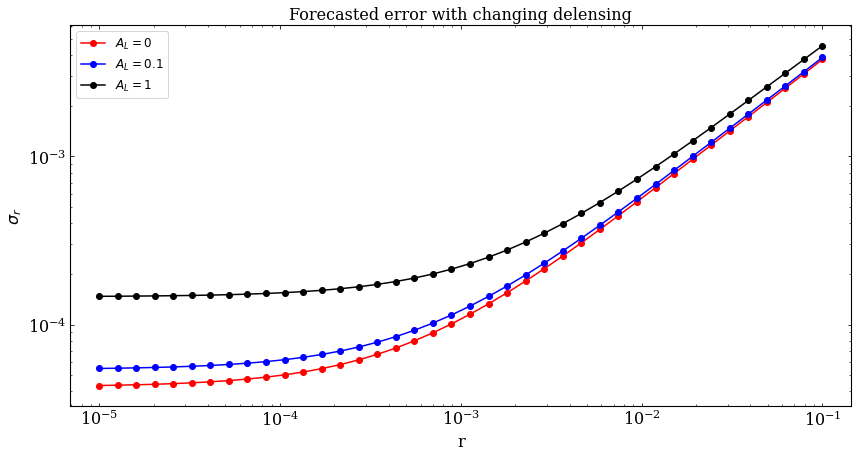

In [41]:
plt.figure(figsize = (14, 7))
r_val = np.geomspace(1e-5, 1e-1, 40)
plt.loglog(np.geomspace(1e-5, 1e-1, 40), sig_0, 'ro-', label = '$A_{L} = 0$')
plt.loglog(np.geomspace(1e-5, 1e-1, 40), sig_01, 'bo-', label = '$A_{L} = 0.1$')
plt.loglog(np.geomspace(1e-5, 1e-1, 40), sig_1, 'ko-', label = '$A_{L} = 1$')

plt.title('Forecasted error with changing delensing')
plt.xlabel('r')
plt.ylabel('$\sigma_r$')

plt.legend()

# 8. Lensing Residue Constraints

In [42]:
cl_lensed_6 = Cl_bb_lensed(1e-6, 1000)

In [43]:
# mi and ma is the range of multipole (l)

def r_forecast_lensing(Cl_r, Cl_lensed, A_l, dfs, f_sky, mi, ma, n_params):

    n_ell = (((mv_comb[mi:ma]/(2.726**2))*10**-12)*(el[mi:ma]*(el[mi:ma]+1)))/(2*np.pi)

    Cl_Al = Cl_lensed * A_l
    Cl_total = Cl_r[mi+1:ma+1] + Cl_Al[mi+1:ma+1]

    F = np.zeros((n_params, n_params))
    for i in range(n_params):
        for j in range(n_params):
            Fij_ell = (((2*l[mi-2:ma-2] + 1)/2) * ((Cl_total + n_ell)**(-2)) * ((dfs[i])[mi+1:ma+1]*(dfs[j])[mi+1:ma+1]))*f_sky
            F[i, j] = np.sum(Fij_ell)
    cov = la.inv(F)
    sigmas = np.diagonal(cov)**0.5
    
    return sigmas

In [44]:
new_dfs = dfs_6[2:12]
new_dfs.append(cl_lensed_6)

In [45]:
new_dfs

[array([0.00000000e+00, 0.00000000e+00, 9.48576827e-23, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 8.96206632e-20, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 5.85670651e-17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 1.71202199e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 2.31940595e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 8.43484838e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([ 0.00000000e+00,  0.00000000e+00,  1.11764916e-17, ...,
        -8.22846046e-30, -2.35098870e-30,  0.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 2.41711286e-19, ...,
        1.46349138e-20, 1.51992832e-20, 1.60103007e-20]),
 array([0.00000000e+00, 0.00000000e+00, 4.

In [ ]:
# mi and ma is the range of multipole (l)

def r_forecast_lensing(Cl_r, Cl_lensed, A_l, dfs, f_sky, mi, ma, n_params):

    n_ell = (((mv_comb[mi:ma]/(2.726**2))*10**-12)*(el[mi:ma]*(el[mi:ma]+1)))/(2*np.pi)

    Cl_Al = Cl_lensed * A_l
    Cl_total = Cl_r[mi+1:ma+1] + Cl_Al[mi+1:ma+1]

    F = np.zeros((n_params, n_params))
    for i in range(n_params - 1):
        for j in range(n_params - 1):
            Fij_ell = (((2*l[mi-2:ma-2] + 1)/2) * ((Cl_total + n_ell)**(-2)) * ((dfs[i])[mi+1:ma+1]*(dfs[j])[mi+1:ma+1]))*f_sky
            F[i, j] = np.sum(Fij_ell)
    cov = la.inv(F)
    sigmas = np.diagonal(cov)**0.5
    
    return sigmas

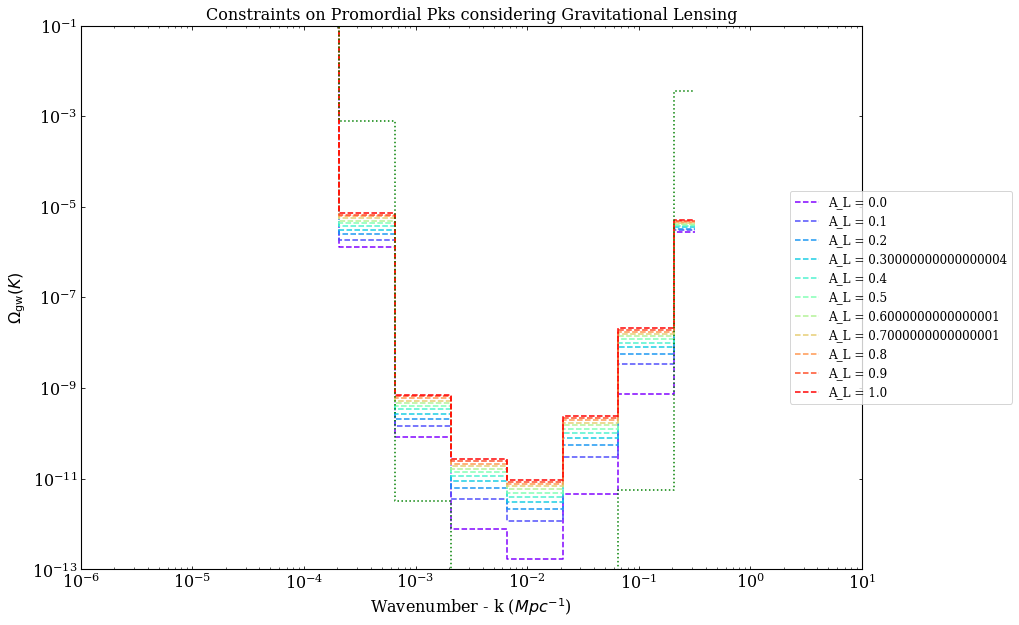

In [46]:
colors = cm.rainbow(np.linspace(0, 1, 11))
A_l_val = np.linspace(0.0, 1, 11)

index = 0
for i in A_l_val:
    lensed_sigma = r_forecast_lensing(bb_6, cl_lensed_6, i, new_dfs, f_sky, mi, ma, 11)
    pk_err_lensed = lensed_sigma * A_s
    plt.loglog()
    plt.step(k_center[2:12], pk_err_lensed[0:10], drawstyle="steps", where = 'mid', color = colors[index], linestyle = '--', label = 'A_L = ' + str(A_l_val[index]))
    index += 1
    
    plt.xlim([1e-6, 10])
    plt.xlim([1e-6, 10])
    plt.ylim([1e-13, 1e-1])
    
    plt.xlabel('Wavenumber - k ($Mpc^{-1}$) ')
    plt.ylabel('$\Omega_\mathrm{gw}(K)$')
    plt.title('Constraints on Promordial Pks considering Gravitational Lensing')
    plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
    
plt.step(k_center[2:12], pk_err_6, drawstyle="steps", where = 'mid', color = 'green', linestyle = ':', label = 'constraints $r = 1\\times10^{-6}$')


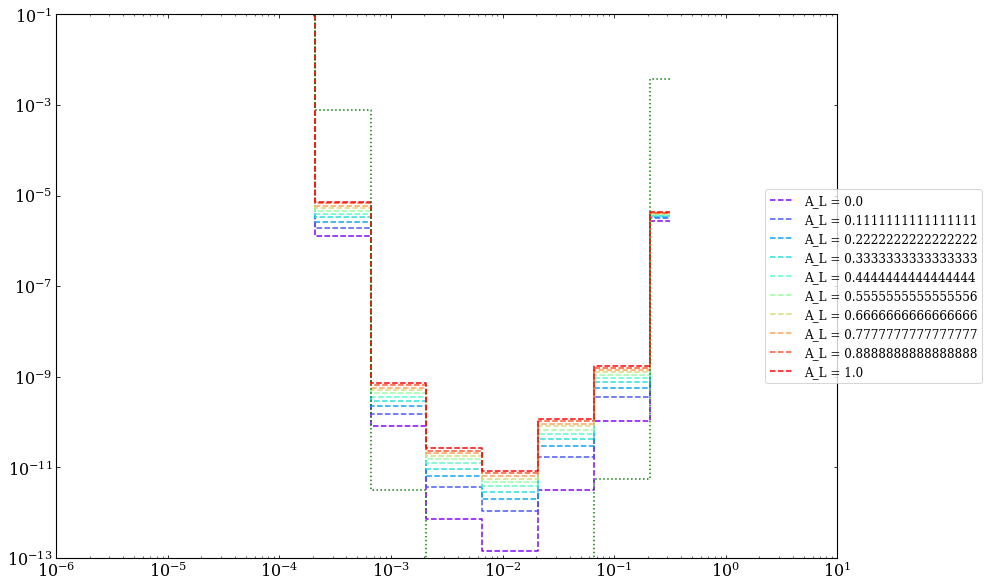

In [53]:
colors = cm.rainbow(np.linspace(0, 1, 10))
A_l_val = np.linspace(0.0, 1, 10)

index = 0
for i in A_l_val:
    lensed_sigma = r_forecast_lensing(bb_6, cl_lensed_6, i, new_dfs, f_sky, mi, ma, 10)
    pk_err_lensed = lensed_sigma * A_s
    plt.loglog()
    plt.step(k_center[2:12], pk_err_lensed[0:10], drawstyle="steps", where = 'mid', color = colors[index], linestyle = '--', label = 'A_L = ' + str(A_l_val[index]))
    index += 1
    
    plt.xlim([1e-6, 10])
    plt.xlim([1e-6, 10])
    plt.ylim([1e-13, 1e-1])
    plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
    
plt.step(k_center[2:12], pk_err_6, drawstyle="steps", where = 'mid', color = 'green', linestyle = ':', label = 'constraints $r = 1\\times10^{-6}$')


In [ ]:
%store -r el_camb
%store -r cl_cmb
%store -r dl_cmb

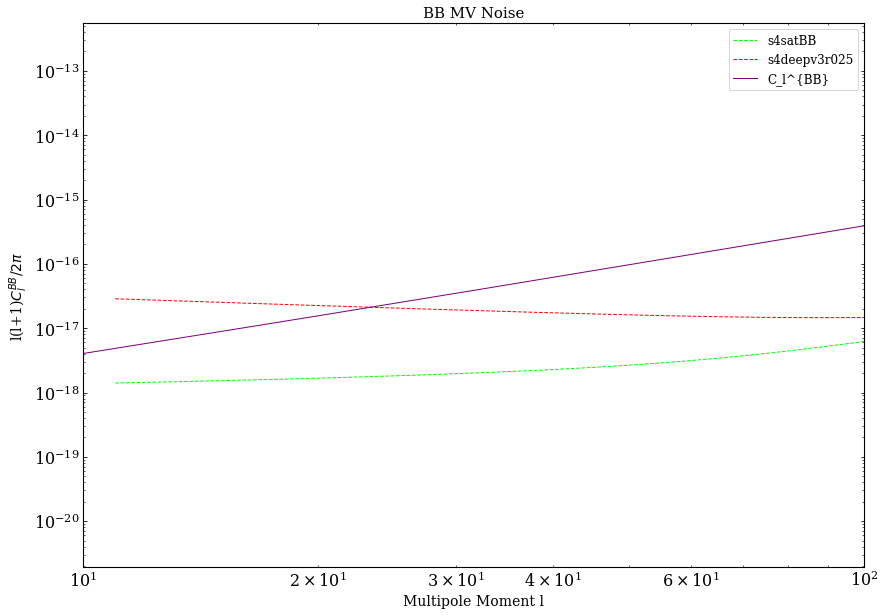

In [138]:
plt.loglog(el[11:1001], noise[11:1001], 'lime', ls = '--', lw = 1., label = 's4satBB')
plt.loglog(high_el[11:1001], high_dll_noise[11:1001], 'red', ls = '--', lw = 1., label = 's4deepv3r025')
plt.loglog(el_camb, dl_cmb, 'purple', lw = 1., label = 'C_l^{BB}')

plt.xlim(10, 100)

plt.xlabel('Multipole Moment l', fontsize = 14)
plt.ylabel('l(l+1)$C_{l}^{BB}$/$2\\pi$', fontsize = 14)
plt.title('BB MV Noise', fontsize = 15)

plt.legend()